In [14]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random as rd

In [15]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [16]:
def align_images(images, num_bits):
    num_images = len(images)
    gray_images = []
    for i in range(num_images):
        gray_images.append(cv.cvtColor(images[i], cv.COLOR_BGR2GRAY))
        
    # Compute median threshold bitmap
    median_image = np.median(gray_images, axis=0).astype(np.uint8)
    bitmap_images = []
    for i in range(num_images):
        bitmap_images.append((gray_images[i] > median_image).astype(np.uint8))
        
    # Compute shift matrices using bitmap images
    shift_matrices = []
    for i in range(num_images):
        shift_matrices.append(np.zeros((2,3), dtype=np.float32))
    for bit in range(num_bits):
        for i in range(num_images):
            if bit == 0:
                continue
            prev_bitmap = bitmap_images[i-1]
            curr_bitmap = bitmap_images[i]
            diff = curr_bitmap.astype(np.int16) - prev_bitmap.astype(np.int16)
            shift = np.zeros((2,), dtype=np.float32)
            for y in range(diff.shape[0]):
                for x in range(diff.shape[1]):
                    if diff[y,x] == 1:
                        shift[1] += y
                        shift[0] += x
                    elif diff[y,x] == -1:
                        shift[1] -= y
                        shift[0] -= x
            shift /= np.sum(np.abs(shift))
            shift_matrices[i][:,2] += (2**bit) * shift
        
    # Apply shift matrices to images
    aligned_images = []
    for i in range(num_images):
        aligned_images.append(cv.warpAffine(images[i], shift_matrices[i], 
                                              gray_images[i].shape[::-1], 
                                              flags=cv.INTER_LINEAR))
    return aligned_images

In [17]:
def sample_pixels(images, num_samples):
    
    # Choose pixels with largest standard deviation
    stds = np.std(images, axis=0)
    selected_pixel_value = np.argsort(stds.ravel())[::-1][:num_samples]
    sampled_pixels = np.unravel_index(selected_pixel_value, stds.shape) 
    # returns (i of chosen pixels, j of chosen pixels)
    
    # Compute the sample values for each pixel
    samples = np.zeros((num_samples, len(images)), dtype=np.float32)
    for i in range(num_samples):
        x, y = sampled_pixels[0][i], sampled_pixels[1][i]
        for j in range(len(images)):
            samples[i, j] = images[j][x, y]
    
    return samples
    # returns [ [first chosen pixel in every image], [], ..... [] ]

In [22]:
def solve_respond_curve(z,lgT,lam,w):
    #z : ith pixel of those chosen in jth image
    n = len(z) #n : we choose n pixels total for each images
    p = len(z[0])#p : we choose p images total 
    row = n*p + 1 + 254
    col = 256 + n   # row and col in matrix a
    a = [[] for i in range(row)]
    b = [[] for i in range(row)]

    #initialize matrix a(zero) and b(zero)
    for i in range(row):
        b[i].append(0)
        for j in range(col):
            a[i].append(0)

    #upper half of matrix a and b done
    for j in range(p):
        for i in range(n):
            Z = int(z[i][j])
            b[i+j*n][0] = lgT[j] * w[Z]
            for r in range(256):
                if r == Z :
                    a[i+j*n][r] = 1 * w[Z]
            a[i+j*n][i] = -1 * w[Z]

    #fix the curve by setting its middle value to 0
    a[n*p][128] = 1

    #lower half of matrix a and b done
    for k in range(n*p+1,n*p+255):
        for l in range(255):
            a[k][l] = 1 * w[l+1] * lam 
            a[k][l+1] = -2 * w[l+1] * lam 
            a[k][l+2] = 1 * w[l+1] * lam 
            
    
    A = np.array(a)
    B = np.array(b)

    print(np.shape(A))
    print(np.shape(B))
    #Solve the system using SVD
    x = np.linalg.lstsq(A,B)[0]
    g = x[:256]
    lE = x[256:]
    
    return g, lE

(50255, 5256)
(50255, 1)
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [ 50 100 150 ...   0   0   0]
 [ 50 100 150 ...   0   0   0]
 [ 50 100 150 ...   0   0   0]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


/var/folders/bz/qpg9g_nj7lx_0r49_7jyc15c0000gp/T/ipykernel_48138/1548890690.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A,B)[0]


(50255, 5256)
(50255, 1)
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [ 50 100 150 ...   0   0   0]
 [ 50 100 150 ...   0   0   0]
 [ 50 100 150 ...   0   0   0]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(50255, 5256)
(50255, 1)
[[  0   0   0 ...   0   0   0]
 [  0  -3   0 ...   0   0   0]
 [  0   0  -2 ...   0   0   0]
 ...
 [ 50 100 150 ...   0   0   0]
 [ 50 100 150 ...   0   0   0]
 [ 50 100 150 ...   0   0   0]]
[[0.]
 [3.]
 [2.]
 ...
 [0.]
 [0.]
 [0.]]


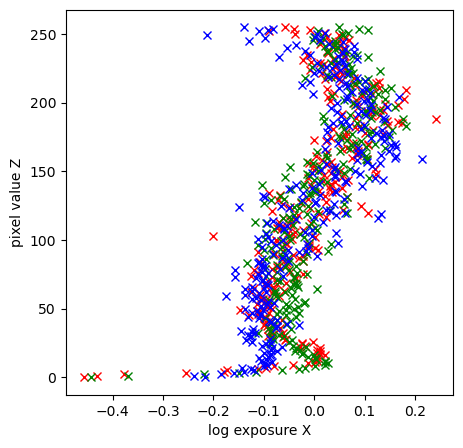

In [23]:
if __name__ == '__main__':
    folder = "work_image" # for now
    images = load_images(folder)
    images = np.array(images)
    #aligned_images = np.array(align_images(images, 3))
    num_samples = 5000 # for now

    z0 = sample_pixels(images[:,:,:,0], num_samples)
    z1 = sample_pixels(images[:,:,:,1], num_samples)
    z2 = sample_pixels(images[:,:,:,2], num_samples)
    
    exposure_times = [1, 1/1.6, 1/2.5, 1/4, 1/6, 1/10, 1/15, 1/25, 1/40, 1/50] # for now
    lambda_ = 50 # for now
    w = [value if value <= 0.5*255 else 255-value for value in range(256)]
    
    gB, _ = solve_respond_curve(z0, exposure_times, lambda_, w)
    gG, _ = solve_respond_curve(z1, exposure_times, lambda_, w)
    gR, _ = solve_respond_curve(z2, exposure_times, lambda_, w)

    

    plt.figure(figsize=(5, 5))
    plt.plot(gR, range(256), 'rx')
    plt.plot(gG, range(256), 'gx')
    plt.plot(gB, range(256), 'bx')
    plt.ylabel('pixel value Z')
    plt.xlabel('log exposure X')

    
    
    